In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

BATCH_SIZE = 8
images_path = "training/preprocessed_images"
groundtruths_path = "../training/groundtruth"
orig_images_path = "../training/images"

In [2]:
return_orig = False

In [3]:
class CustomDataset(Dataset):
    def __init__(self):
        self.image_files = os.listdir(images_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        name = self.image_files[idx][:-4]
        # print("loading " + name)

        image = torch.tensor(np.load(os.path.join(images_path, name + ".npy")), dtype=torch.float32).squeeze(0)
        groundtruth:Image = Image.open(os.path.join(groundtruths_path, name + ".png"))
        gt_tensor = torch.tensor(np.array(groundtruth),dtype=torch.float32).unsqueeze(0)/255

        if return_orig:
            orig = Image.open(os.path.join(orig_images_path, name + ".png"))
            orig = torch.tensor(np.array(orig),dtype=torch.float32)/255
        else:
            orig = torch.tensor(np.array([]),dtype=torch.float32)

        return image, gt_tensor,orig


In [4]:
# Read images
dataset = CustomDataset()

# Split the dataset
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
# Create a model with a single layer
head = nn.Conv2d(768, 1, kernel_size=(1, 1), stride=(1, 1))

# Set up training
optimizer = optim.AdamW(head.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
def train(model, dataset, optimizer):
    model.train()
    total_loss = 0
    for x, y, _ in tqdm(dataset):
        x, y = x.cuda(), y.cuda()     
        optimizer.zero_grad()
        y_pred = model(x)
        y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Training Loss:", total_loss / len(dataset))
    wandb.log({"Train Loss": total_loss / len(dataset)})

def validate(model, dataset):
    model.eval()
    val_f1_scores = []

    with torch.no_grad():
        for x, y, _ in dataset:
            x, y = x.cuda(), y.cuda()  
            y_pred = model(x)
            y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
            y_pred = torch.sigmoid(y_pred)
            y_pred = (y_pred > 0.5).float()
            val_f1_scores.append(f1_score(y.cpu().flatten(), y_pred.cpu().flatten()))

    return sum(val_f1_scores) / len(val_f1_scores)

# Initialize wandb
wandb.init(project="CIL 2023", entity="tlaborie")
wandb.watch(head, log="all")

# Train and report the validation F1 score
num_epochs = 5
head = head.cuda()
for epoch in range(num_epochs):
    train(head, train_loader, optimizer)
    val_f1 = validate(head, val_loader)
    print("Validation F1 Score:", val_f1)
    wandb.log({"Validation F1 Score": val_f1})

wandb.finish()


c:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


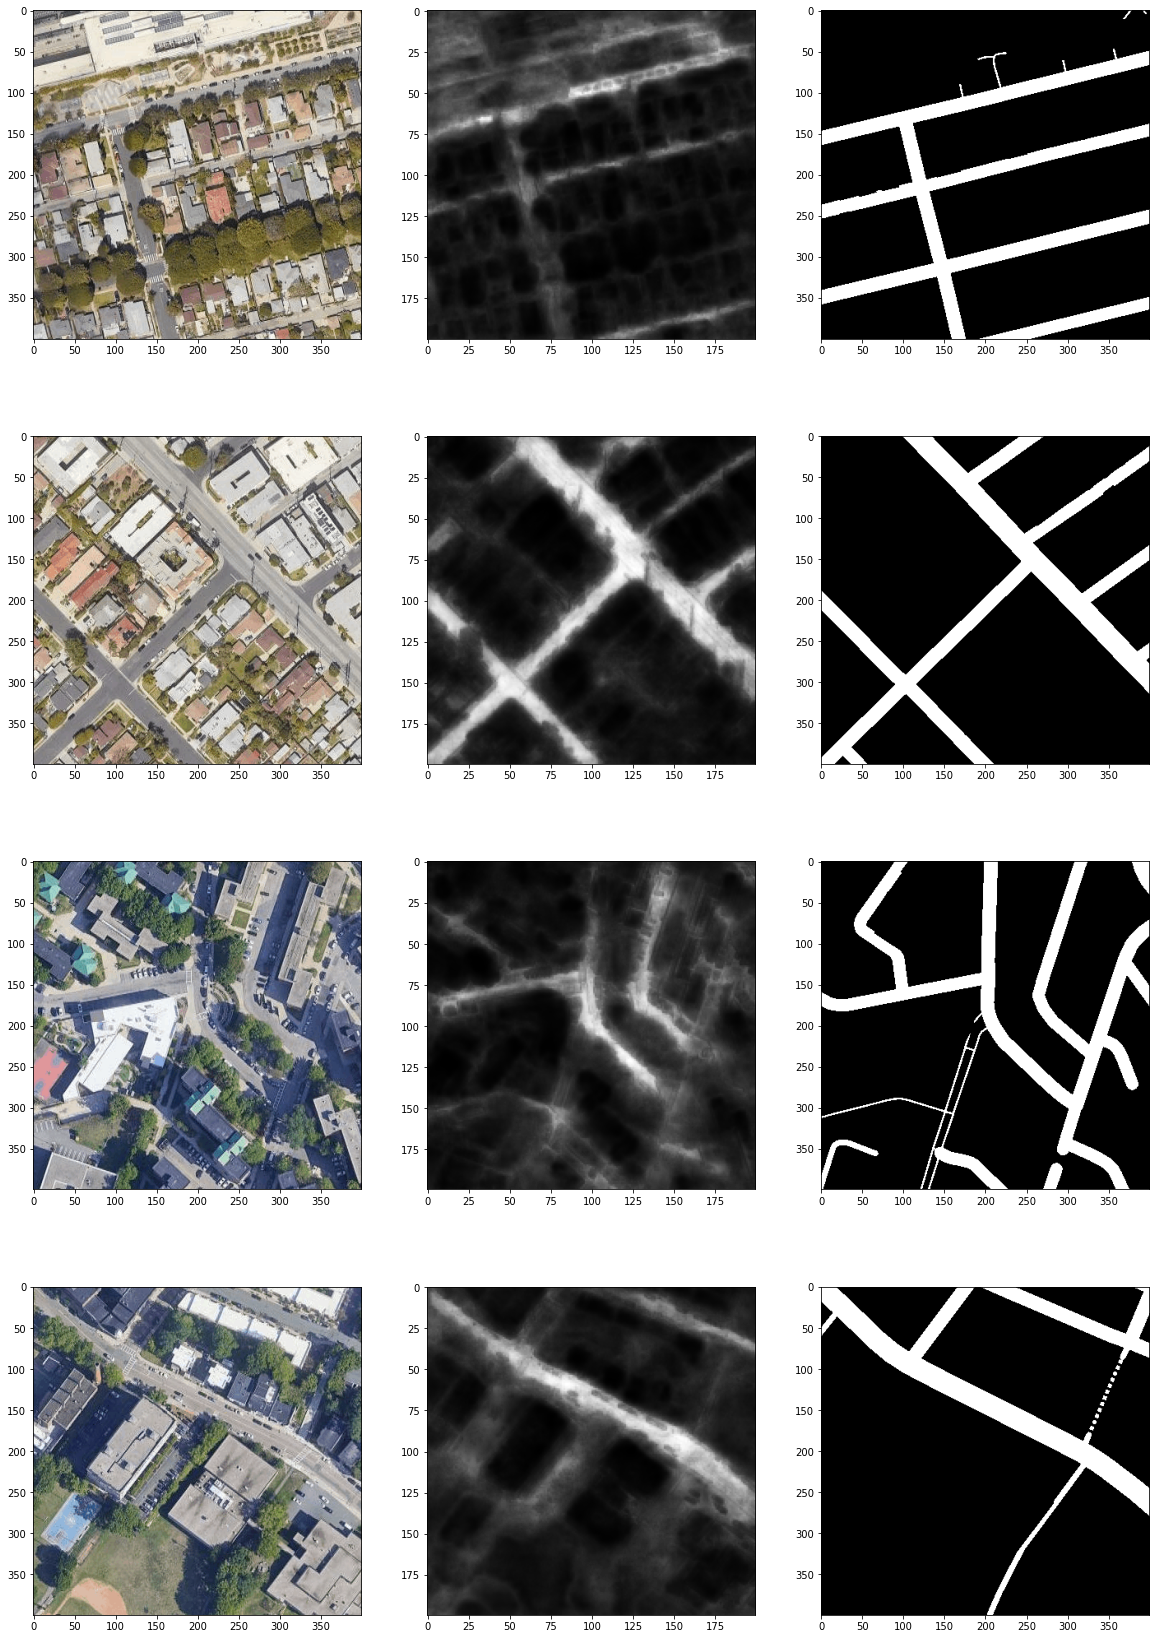

In [6]:
return_orig = True
with torch.no_grad():
    # visualize the output
    img_count = 4
    fig, ax = plt.subplots(img_count, 3, figsize=(20, 30))
    head = head.cpu()
    for i, (x, y, orig) in enumerate(val_loader):
        x = x[0]
        y = y[0]
        orig = orig[0]

        # print(x.shape)
        # print(y.shape)
        # print(orig.shape)

        pred = head(x)
        # print(pred.shape)
        pred = F.sigmoid(pred).permute(1, 2, 0)
        gt = y.permute(1, 2, 0)

        # print(orig.shape)
        # print(pred.shape)
        # print(gt.shape)

        # print(orig)
        # print(pred)
        # print(gt)

        ax[i][0].imshow(orig)
        ax[i][1].imshow(pred, cmap='gray')
        ax[i][2].imshow(gt, cmap='gray')

        if i == img_count - 1:
            break
